# Proyecto de predicción de fugas de clientes en compañía telefónica
### Script por Manuel Sánchez-Montañés

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [2]:
COLAB = True

In [3]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1r1Ra_blgNSvtgMmwxESk0pJ8o4qcMWfF',
                                        dest_path='./fuga_clientes_empresa_telefonica_construccion.csv')
    gdd.download_file_from_google_drive(file_id='1yPBvhHcg90ADaypGGoGzWUI1UDGVwQR4',
                                        dest_path='./fuga_clientes_empresa_telefonica_explotacion.csv')

## **Funciones auxiliares**

In [4]:
def analisis_roc(y_true, y_probas_predicted, POSITIVE_CLASS=1):
    s = y_probas_predicted.shape
    if len(s) == 1:
        positive_class_scores = y_probas_predicted
    elif len(s) == 2 and s[1] == 1:
        positive_class_scores = y_probas_predicted[:,0]
    else:
        positive_class_scores  = y_probas_predicted[:,POSITIVE_CLASS]

    fpr, tpr, thresholds = roc_curve(y_true,
                                     positive_class_scores,
                                     pos_label=POSITIVE_CLASS)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC. Positive class: '+str(POSITIVE_CLASS))
    plt.legend(loc="lower right");


def plot_confusion_matrix(y_true, y_predicted,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_predicted)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    classes = np.unique(y_test)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

In [5]:
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss,
                          figsize=(10,4)):
    #best_i = np.argmax(val_acc)
    best_i = np.argmin(val_loss)
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

## **Carga de los datos**

In [6]:
df = pd.read_csv("./fuga_clientes_empresa_telefonica_construccion.csv")

In [7]:
pd.options.display.max_columns = None

In [8]:
df

,Customer ID,network_age,Customer tenure in month,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Churn Status,Most Loved Competitor network in in Month 1_0,Most Loved Competitor network in in Month 1_Mango,Most Loved Competitor network in in Month 1_PQza,Most Loved Competitor network in in Month 1_ToCall,Most Loved Competitor network in in Month 1_Uxaa,Most Loved Competitor network in in Month 1_Weematel,Most Loved Competitor network in in Month 1_Zintel,Most Loved Competitor network in in Month 2_Mango,Most Loved Competitor network in in Month 2_PQza,Most Loved Competitor network in in Month 2_ToCall,Most Loved Competitor network in in Month 2_Uxaa,Most Loved Competitor network in in Month 2_Weematel,Most Loved Competitor network in in Month 2_Zintel
0,ADF0039,123,4.10,76.7140,0.00,1.25,1.4951,14,564,6408,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,ADF0041,1316,43.87,98.8904,4.14,1.25,1.0244,27,1626,4373,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,ADF0051,2385,79.50,372.6300,3.51,1.25,6.0898,119,10411,22039,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,ADF0059,1614,53.80,530.2000,6.85,1.25,3.3447,69,6822,6274,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,ADF0060,2175,72.50,554.1300,6.99,153.75,673204.0342,33,3387,7241,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,ADF1290,3994,133.13,804.0848,7.00,0.00,2364.6768,127,30071,8091,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1106,ADF1302,731,24.37,828.7404,3.52,2.50,35674.9864,660,10912,20756,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1107,ADF1304,2971,99.03,832.7248,9.62,2.50,103008.5605,224,37401,29553,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1108,ADF1308,595,19.83,839.5724,73.80,8.75,229.4463,102,21304,7894,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [9]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

df[:5].T

,0,1,2,3,4
Customer ID,ADF0039,ADF0041,ADF0051,ADF0059,ADF0060
network_age,123,1316,2385,1614,2175
Customer tenure in month,4.1,43.87,79.5,53.8,72.5
Total Spend in Months 1 and 2 of 2017,76.714,98.8904,372.63,530.2,554.13
Total SMS Spend,0.0,4.14,3.51,6.85,6.99
Total Data Spend,1.25,1.25,1.25,1.25,153.75
Total Data Consumption,1.4951,1.0244,6.0898,3.3447,673204.0342
Total Unique Calls,14,27,119,69,33
Total Onnet spend,564,1626,10411,6822,3387
Total Offnet spend,6408,4373,22039,6274,7241


In [10]:
print(df.shape)
df.describe().T[["count", "min", "max", "mean", "std"]]

(1110, 25)


,count,min,max,mean,std
network_age,1110.0,-5.0000,5451.00,1.512039e+03,1.272024e+03
Customer tenure in month,1110.0,-0.1700,181.70,5.040138e+01,4.240068e+01
Total Spend in Months 1 and 2 of 2017,1110.0,4.9100,24438.83,8.350399e+02,1.317851e+03
Total SMS Spend,1110.0,0.0000,665.00,3.068709e+01,5.862510e+01
Total Data Spend,1110.0,0.0000,8295.00,6.716291e+01,3.237141e+02
Total Data Consumption,1110.0,0.0586,99456402.05,2.343397e+06,7.343873e+06
Total Unique Calls,1110.0,1.0000,2184.00,2.030432e+02,3.002578e+02
Total Onnet spend,1110.0,0.0000,146344.00,6.066100e+03,1.196962e+04
Total Offnet spend,1110.0,0.0000,384648.00,1.627347e+04,3.723065e+04
Total Call centre complaint calls,1110.0,1.0000,49.00,1.986486e+00,2.497392e+00


<ipython-input-11-4e96f5640855>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(df.corr(), cmap="bwr", vmin=-1, vmax=1);


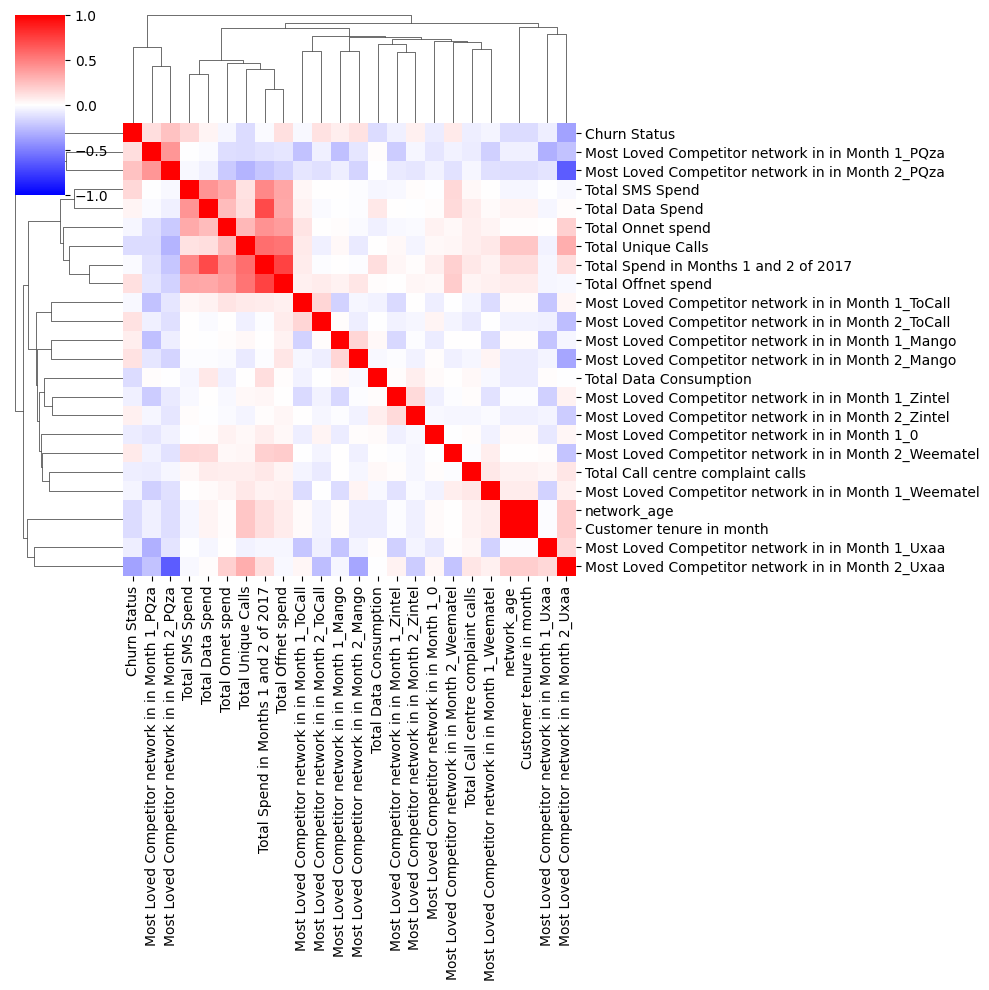

In [11]:
sns.clustermap(df.corr(), cmap="bwr", vmin=-1, vmax=1);

In [12]:
df["network_age"] / df["Customer tenure in month"]

0       30.000000
1       29.997721
2       30.000000
3       30.000000
4       30.000000
5       29.981025
6       29.972752
7       30.000000
8       30.026110
9       29.998394
10      29.997492
11      30.000000
12      29.975430
13      30.000000
14      29.998593
15      30.000000
16      30.000000
17      30.000858
18      29.992893
19      30.000000
20      30.001647
21      30.000000
22      29.998735
23      29.999143
24      30.024814
25      29.998759
26      30.000000
27      30.000000
28      30.003542
29      30.000000
30      30.000000
31      29.997623
32      29.998593
33      30.000895
34      30.000000
35      29.997197
36      30.000000
37      29.999192
38      29.983793
39      30.002104
40      29.991850
41      29.991916
42      29.998109
43      30.000000
44      30.000000
45      30.000000
46      30.000000
47      29.997907
48      30.024213
49      30.000000
50      29.995276
51      30.000000
52      29.996771
53      30.000000
54      29.996707
55      30

In [13]:
df.columns

Index(['Customer ID', 'network_age', 'Customer tenure in month',
       'Total Spend in Months 1 and 2 of 2017', 'Total SMS Spend',
       'Total Data Spend', 'Total Data Consumption', 'Total Unique Calls',
       'Total Onnet spend', 'Total Offnet spend',
       'Total Call centre complaint calls', 'Churn Status',
       'Most Loved Competitor network in in Month 1_0',
       'Most Loved Competitor network in in Month 1_Mango',
       'Most Loved Competitor network in in Month 1_PQza',
       'Most Loved Competitor network in in Month 1_ToCall',
       'Most Loved Competitor network in in Month 1_Uxaa',
       'Most Loved Competitor network in in Month 1_Weematel',
       'Most Loved Competitor network in in Month 1_Zintel',
       'Most Loved Competitor network in in Month 2_Mango',
       'Most Loved Competitor network in in Month 2_PQza',
       'Most Loved Competitor network in in Month 2_ToCall',
       'Most Loved Competitor network in in Month 2_Uxaa',
       'Most Loved Compet

In [14]:
df.isnull().sum()

Customer ID                                             0
network_age                                             0
Customer tenure in month                                0
Total Spend in Months 1 and 2 of 2017                   0
Total SMS Spend                                         0
Total Data Spend                                        0
Total Data Consumption                                  0
Total Unique Calls                                      0
Total Onnet spend                                       0
Total Offnet spend                                      0
Total Call centre complaint calls                       0
Churn Status                                            0
Most Loved Competitor network in in Month 1_0           0
Most Loved Competitor network in in Month 1_Mango       0
Most Loved Competitor network in in Month 1_PQza        0
Most Loved Competitor network in in Month 1_ToCall      0
Most Loved Competitor network in in Month 1_Uxaa        0
Most Loved Com

In [15]:
df_expl = pd.read_csv("./fuga_clientes_empresa_telefonica_explotacion.csv")
df_expl.isnull().sum()

Customer ID                                               0
network_age                                               0
Customer tenure in month                                  0
Total Spend in Months 1 and 2 of 2017                     0
Total SMS Spend                                           0
Total Data Spend                                          0
Total Data Consumption                                    0
Total Unique Calls                                        0
Total Onnet spend                                         0
Total Offnet spend                                        0
Total Call centre complaint calls                         0
Churn Status                                            289
Most Loved Competitor network in in Month 1_0             0
Most Loved Competitor network in in Month 1_Mango         0
Most Loved Competitor network in in Month 1_PQza          0
Most Loved Competitor network in in Month 1_ToCall        0
Most Loved Competitor network in in Mont

In [16]:
df.shape, df_expl.shape

((1110, 25), (289, 25))

In [17]:
df_expl

,Customer ID,network_age,Customer tenure in month,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Churn Status,Most Loved Competitor network in in Month 1_0,Most Loved Competitor network in in Month 1_Mango,Most Loved Competitor network in in Month 1_PQza,Most Loved Competitor network in in Month 1_ToCall,Most Loved Competitor network in in Month 1_Uxaa,Most Loved Competitor network in in Month 1_Weematel,Most Loved Competitor network in in Month 1_Zintel,Most Loved Competitor network in in Month 2_Mango,Most Loved Competitor network in in Month 2_PQza,Most Loved Competitor network in in Month 2_ToCall,Most Loved Competitor network in in Month 2_Uxaa,Most Loved Competitor network in in Month 2_Weematel,Most Loved Competitor network in in Month 2_Zintel
0,ADF1330,888,29.60,878.6500,8.76,47.50,1.158052e+05,237,16570,19751,1,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0
1,ADF1331,120,4.00,878.7200,294.00,6.25,6.968163e+05,77,2208,419,3,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0
2,ADF1345,3809,126.97,898.4900,15.75,0.00,4.648857e+05,308,762,6850,2,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0
3,ADF1349,108,3.60,904.3220,155.66,80.00,7.993009e+05,84,27197,1790,1,NaN,0,0,0,0,1,0,0,0,0,0,1,0,0
4,ADF1363,795,26.50,920.1420,0.00,0.00,4.766538e+04,1582,0,2441,2,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0
5,ADF1372,3437,114.57,929.8244,11.87,16.25,7.177168e+02,477,11268,25698,2,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0
6,ADF1403,127,4.23,989.5100,0.00,0.00,9.835160e+01,183,66456,11772,1,NaN,0,0,0,1,0,0,0,0,0,0,1,0,0
7,ADF1404,3098,103.27,989.5200,1.20,12.50,1.290514e+06,557,0,901,2,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0
8,ADF1410,2615,87.17,998.0900,11.96,2.50,1.581541e+06,554,0,1251,1,NaN,0,0,0,0,1,0,0,0,0,0,1,0,0
9,ADF1425,3817,127.23,1042.0400,10.50,76.25,3.268204e+05,393,16236,29519,1,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0


### **Creación de variables sintéticas nuevas**

In [18]:
df["ratio"] = df["Total Unique Calls"] / df["Total Spend in Months 1 and 2 of 2017"]
df_expl["ratio"] = df_expl["Total Unique Calls"] / df_expl["Total Spend in Months 1 and 2 of 2017"]

df["ratio2"] = df["Total Call centre complaint calls"] / df["Total Unique Calls"]
df_expl["ratio2"] = df_expl["Total Call centre complaint calls"] / df_expl["Total Unique Calls"]

### **Chequeo que las columnas del dataset de construcción coinciden con las del dataset de explotación**

In [19]:
print(len(df.columns), len(df_expl.columns))
for n1,n2 in zip(df.columns,df_expl.columns):
    print(n1==n2)

27 27
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## **Análisis exploratorio de datos**

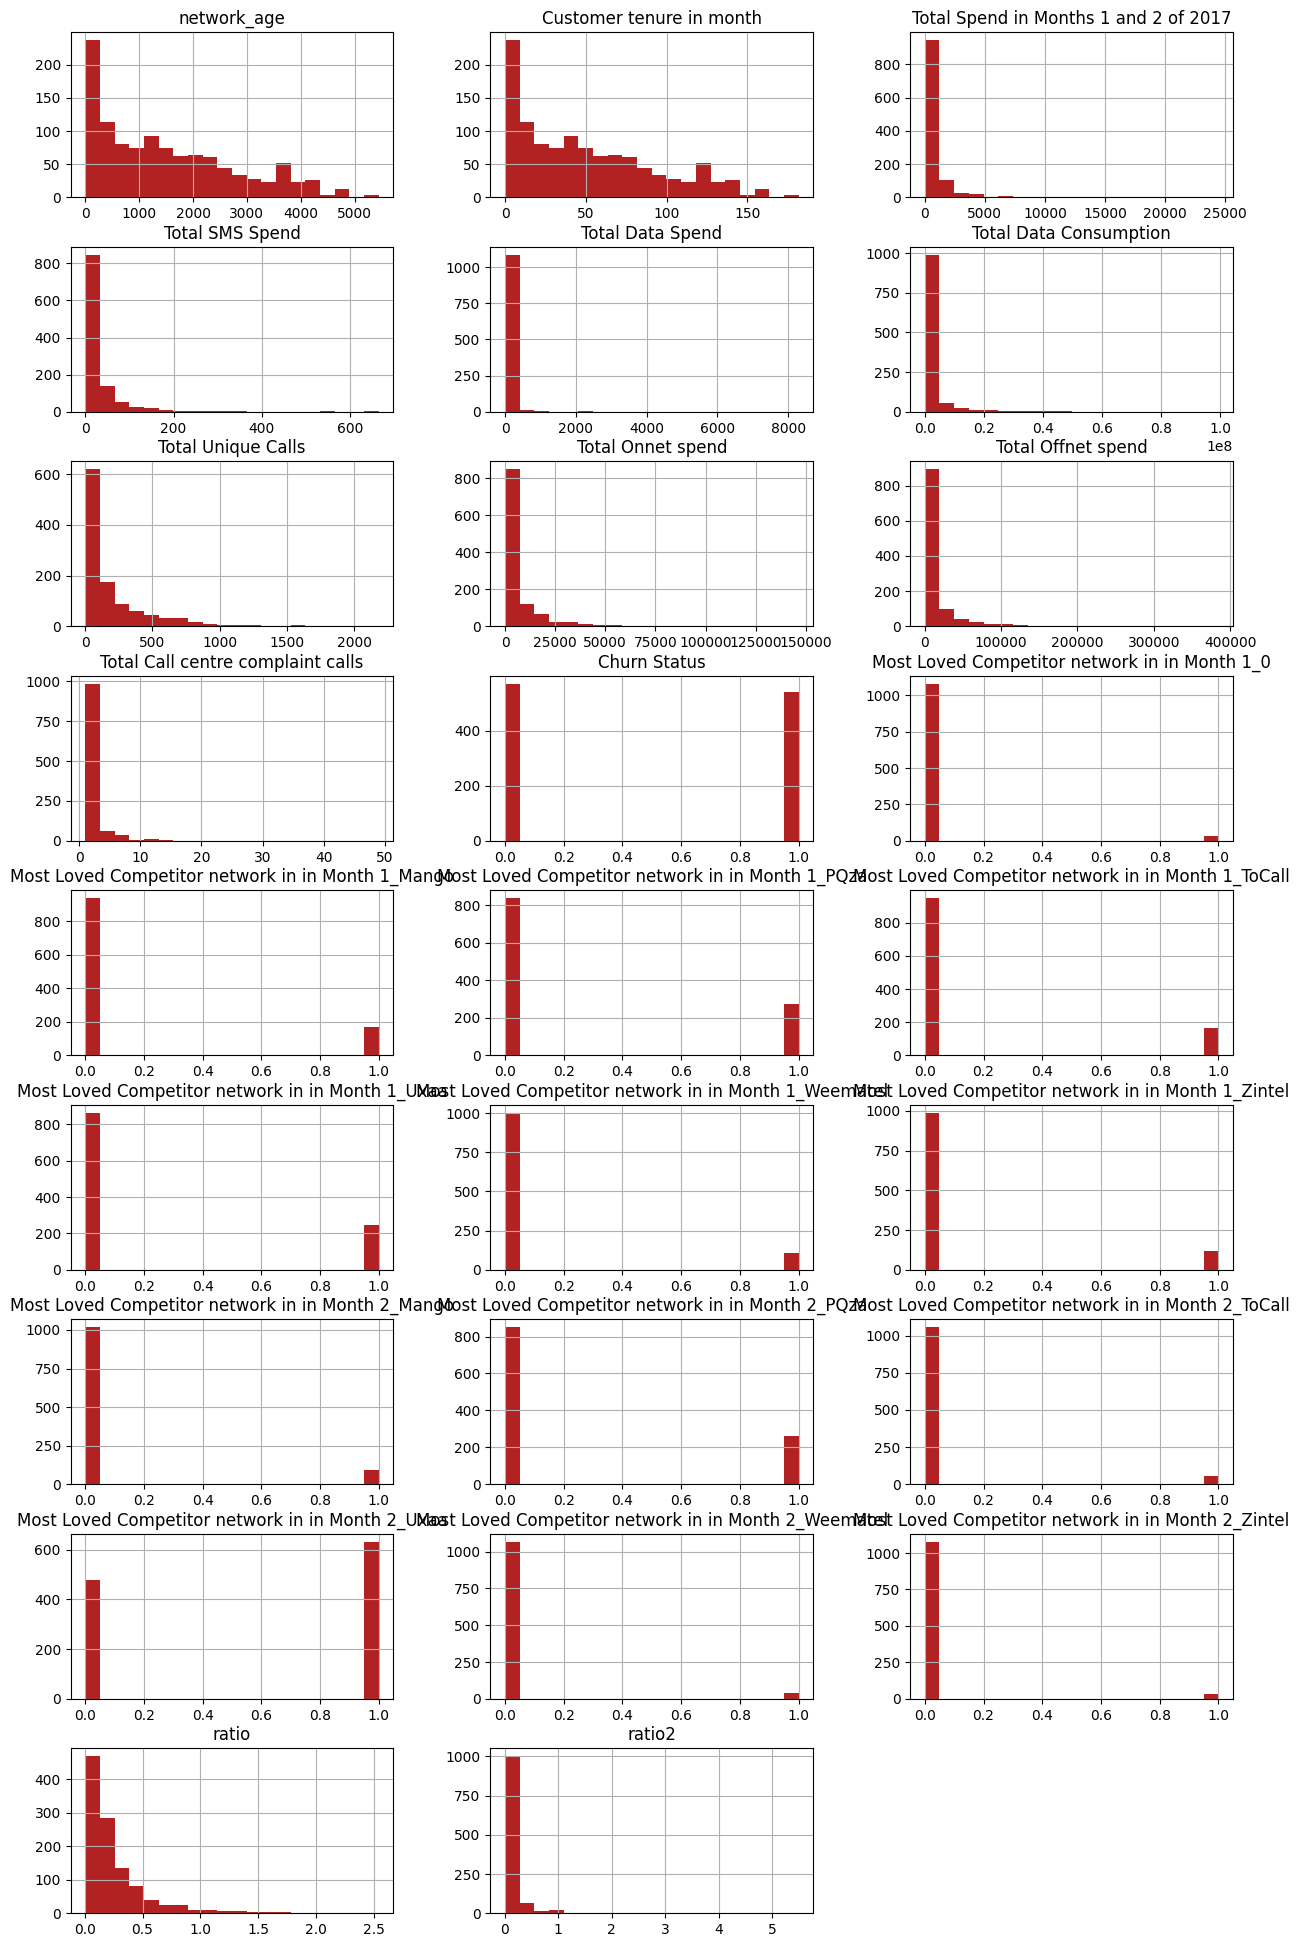

In [20]:
df.hist(color='firebrick', bins=20, layout=(11,3), figsize=(15,30));

<ipython-input-21-0ec127a2fc93>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["Churn Status"]==c][col], hist=False, kde=True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-21-0ec127a2fc93>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexi

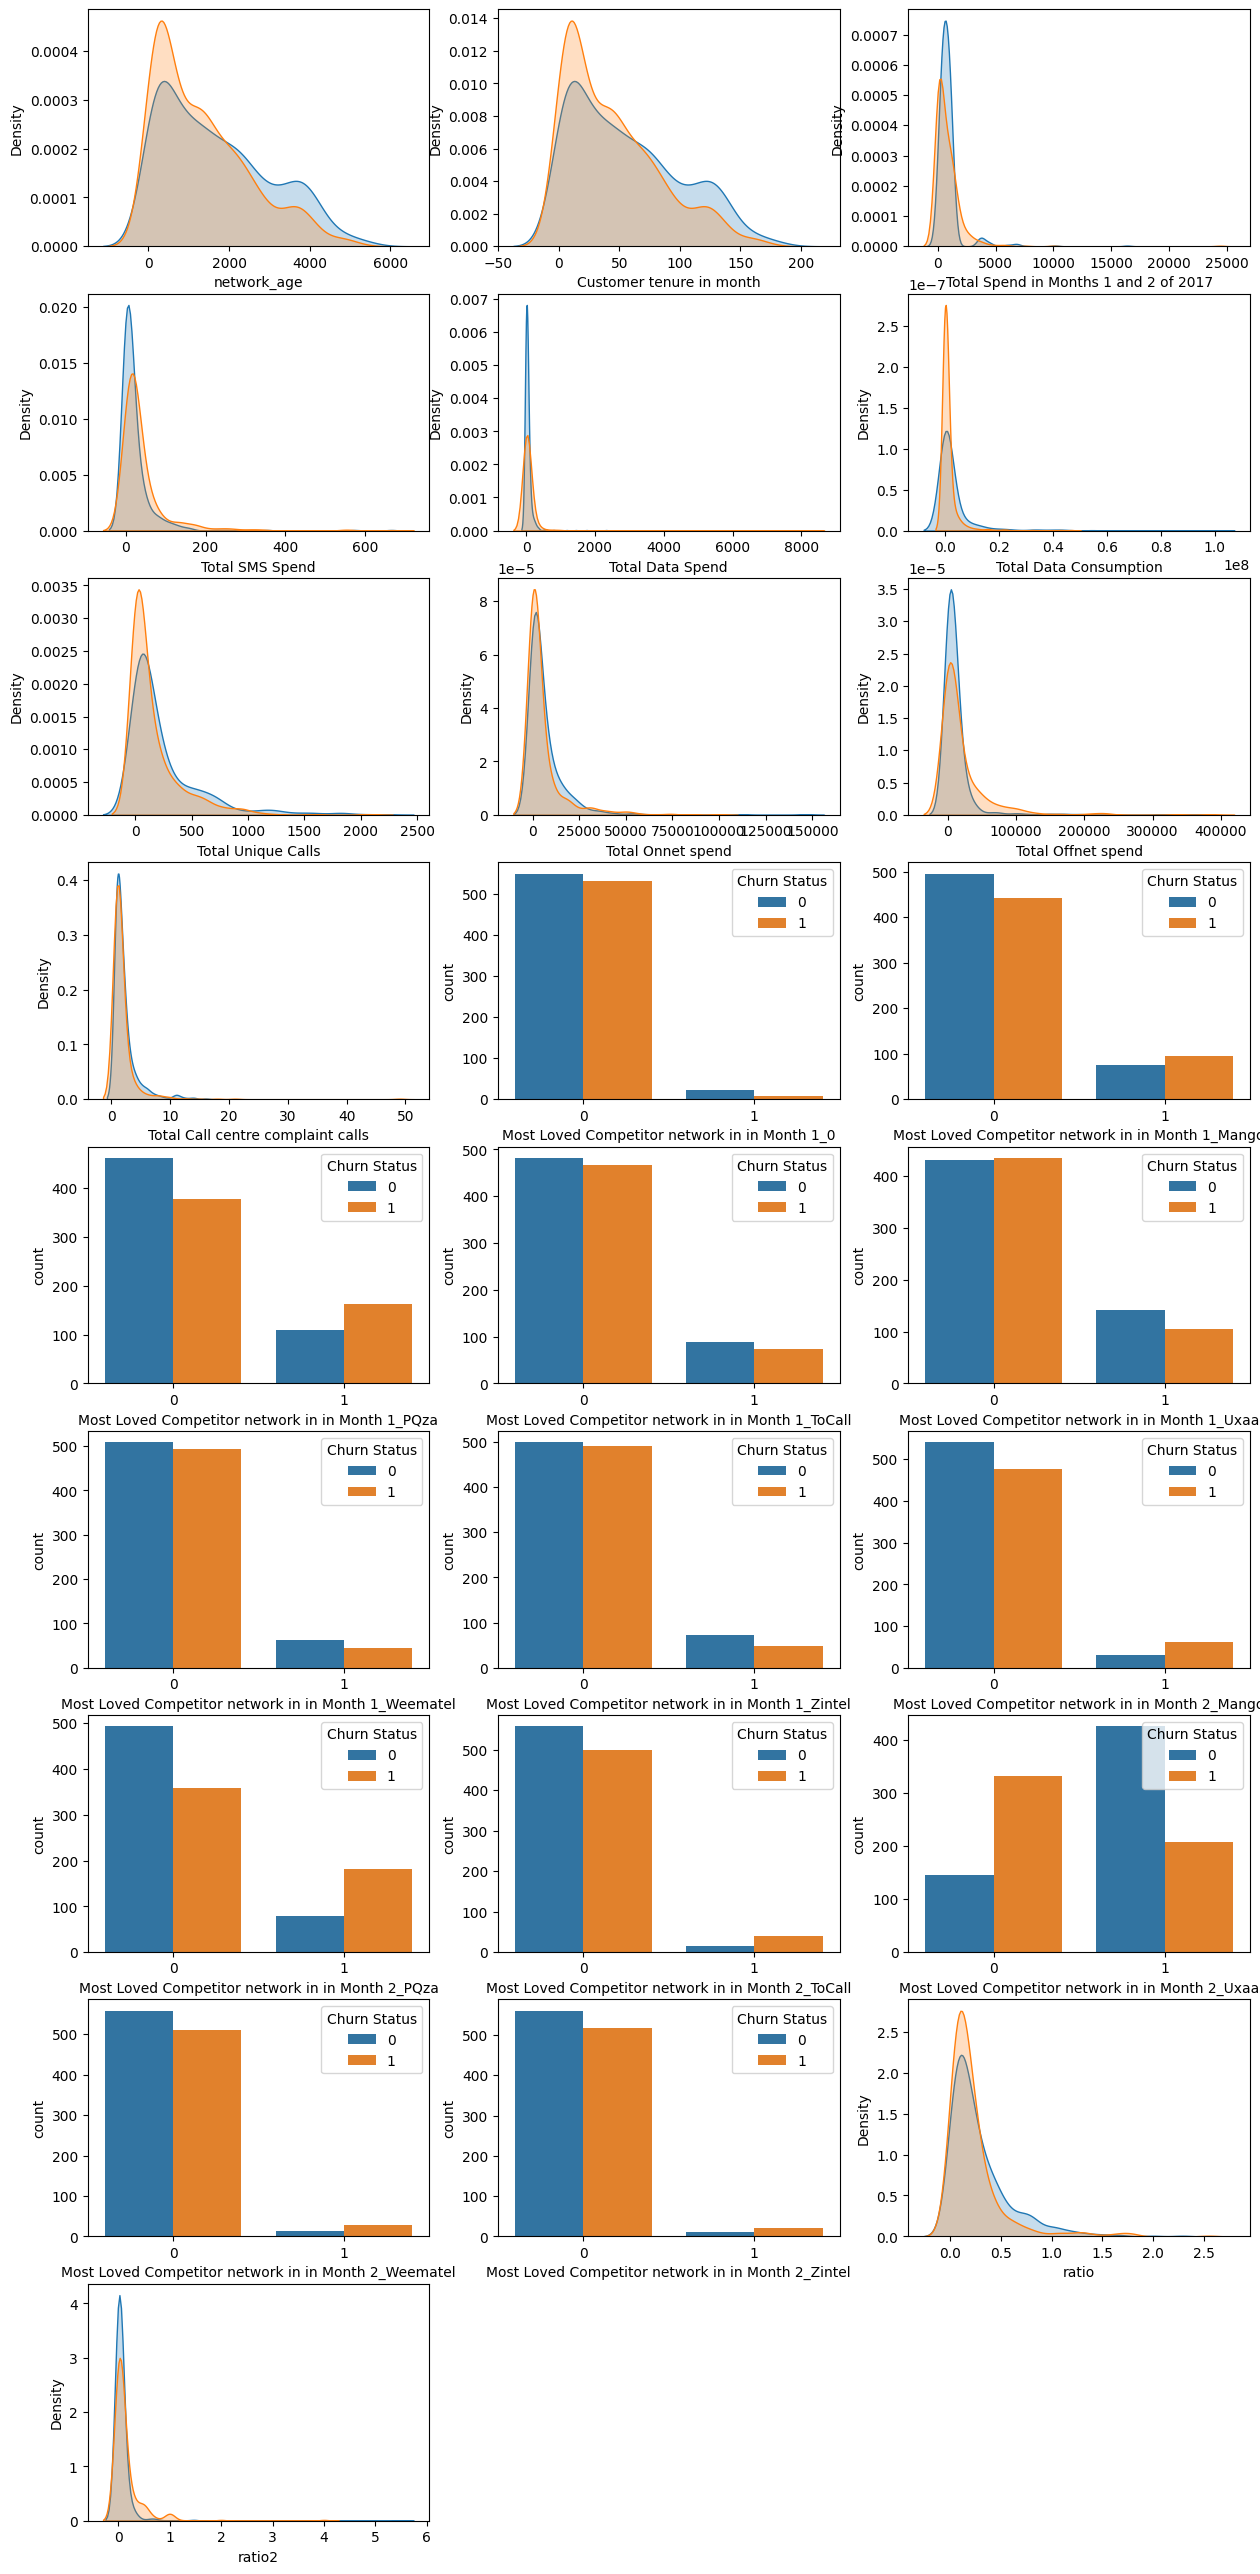

In [21]:
clases = np.unique(df["Churn Status"])
cols = list(df.columns)
cols.remove("Churn Status")
cols.remove("Customer ID")

plt.figure(figsize=(15,40))

for i,col in enumerate(cols):
    plt.subplot(11,3,i+1)
    if len(np.unique(df[col]))>2:
        for c in clases:
            sns.distplot(df[df["Churn Status"]==c][col], hist=False, kde=True,
                         kde_kws = {'shade': True, 'linewidth': 1},
                         label = c)
    else:
        sns.countplot(x=col, hue="Churn Status", data=df)

In [22]:
df.drop("Customer tenure in month", axis=1, inplace=True)
df_expl.drop("Customer tenure in month", axis=1, inplace=True)

## **Construcción del modelo**

A tener en cuenta:

Funciones loss típicas en Keras en problemas de clasificación:

- **binary_crossentropy:** una única neurona de salida con activación **sigmoid**; la "y" es 0/1 (dos clases)
- **categorical_crossentropy:** N neuronas de salida para N clases, las neuronas de salida tienen activación **softmax**. La y está codificada en one-hot (tantas columnas como clases)
- **sparse_categorical_crossentropy:** N neuronas de salida para N clases, las neuronas de salida tienen activación **softmax**. La y es un entero que va de 0 a Nclases-1

In [23]:
df.head(3)

,Customer ID,network_age,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Churn Status,Most Loved Competitor network in in Month 1_0,Most Loved Competitor network in in Month 1_Mango,Most Loved Competitor network in in Month 1_PQza,Most Loved Competitor network in in Month 1_ToCall,Most Loved Competitor network in in Month 1_Uxaa,Most Loved Competitor network in in Month 1_Weematel,Most Loved Competitor network in in Month 1_Zintel,Most Loved Competitor network in in Month 2_Mango,Most Loved Competitor network in in Month 2_PQza,Most Loved Competitor network in in Month 2_ToCall,Most Loved Competitor network in in Month 2_Uxaa,Most Loved Competitor network in in Month 2_Weematel,Most Loved Competitor network in in Month 2_Zintel,ratio,ratio2
0,ADF0039,123,76.7140,0.00,1.25,1.4951,14,564,6408,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.182496,0.142857
1,ADF0041,1316,98.8904,4.14,1.25,1.0244,27,1626,4373,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.273030,0.037037
2,ADF0051,2385,372.6300,3.51,1.25,6.0898,119,10411,22039,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.319352,0.008403


In [24]:
len(df), df["Customer ID"].nunique()

(1110, 1110)

In [25]:
df.set_index("Customer ID", inplace=True)

In [26]:
df.head(5)

,network_age,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Churn Status,Most Loved Competitor network in in Month 1_0,Most Loved Competitor network in in Month 1_Mango,Most Loved Competitor network in in Month 1_PQza,Most Loved Competitor network in in Month 1_ToCall,Most Loved Competitor network in in Month 1_Uxaa,Most Loved Competitor network in in Month 1_Weematel,Most Loved Competitor network in in Month 1_Zintel,Most Loved Competitor network in in Month 2_Mango,Most Loved Competitor network in in Month 2_PQza,Most Loved Competitor network in in Month 2_ToCall,Most Loved Competitor network in in Month 2_Uxaa,Most Loved Competitor network in in Month 2_Weematel,Most Loved Competitor network in in Month 2_Zintel,ratio,ratio2
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,
ADF0039,123,76.7140,0.00,1.25,1.4951,14,564,6408,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.182496,0.142857
ADF0041,1316,98.8904,4.14,1.25,1.0244,27,1626,4373,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.273030,0.037037
ADF0051,2385,372.6300,3.51,1.25,6.0898,119,10411,22039,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.319352,0.008403
ADF0059,1614,530.2000,6.85,1.25,3.3447,69,6822,6274,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.130140,0.014493
ADF0060,2175,554.1300,6.99,153.75,673204.0342,33,3387,7241,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.059553,0.030303


In [27]:
len(df_expl), df_expl["Customer ID"].nunique()

(289, 289)

In [28]:
df_expl.set_index("Customer ID", inplace=True)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
df_trainval, df_test = train_test_split(df, test_size=0.3, random_state=1,
                                        stratify=df["Churn Status"])

In [31]:
df_trainval.head(3)

,network_age,Total Spend in Months 1 and 2 of 2017,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Churn Status,Most Loved Competitor network in in Month 1_0,Most Loved Competitor network in in Month 1_Mango,Most Loved Competitor network in in Month 1_PQza,Most Loved Competitor network in in Month 1_ToCall,Most Loved Competitor network in in Month 1_Uxaa,Most Loved Competitor network in in Month 1_Weematel,Most Loved Competitor network in in Month 1_Zintel,Most Loved Competitor network in in Month 2_Mango,Most Loved Competitor network in in Month 2_PQza,Most Loved Competitor network in in Month 2_ToCall,Most Loved Competitor network in in Month 2_Uxaa,Most Loved Competitor network in in Month 2_Weematel,Most Loved Competitor network in in Month 2_Zintel,ratio,ratio2
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,
ADF0115,2826,792.6188,13.04,5.89,723.5527,131,15682,43586,3,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0.165275,0.022901
ADF1970,2271,4642.3300,5.25,1.25,0.7559,1470,6199,186886,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.316651,0.000680
ADF0599,2081,1230.8200,6.85,23.75,283468.3819,125,7852,41160,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.101558,0.008000


In [32]:
100*df["Churn Status"].value_counts(normalize=True)

0    51.441441
1    48.558559
Name: Churn Status, dtype: float64

In [33]:
100*df_trainval["Churn Status"].value_counts(normalize=True)

0    51.480051
1    48.519949
Name: Churn Status, dtype: float64

In [34]:
100*df_test["Churn Status"].value_counts(normalize=True)

0    51.351351
1    48.648649
Name: Churn Status, dtype: float64

In [35]:
df_train, df_val = train_test_split(df_trainval, test_size=0.3, random_state=1,
                                    stratify=df_trainval["Churn Status"])

In [36]:
100*df_train["Churn Status"].value_counts(normalize=True)

0    51.565378
1    48.434622
Name: Churn Status, dtype: float64

In [37]:
100*df_val["Churn Status"].value_counts(normalize=True)

0    51.282051
1    48.717949
Name: Churn Status, dtype: float64

In [38]:
100*len(df_train)/len(df), 100*len(df_val)/len(df), 100*len(df_test)/len(df)

(48.91891891891892, 21.08108108108108, 30.0)

In [39]:
X_train = df_train.drop("Churn Status", axis=1)
y_train = df_train["Churn Status"]
X_val = df_val.drop("Churn Status", axis=1)
y_val = df_val["Churn Status"]
X_test = df_test.drop("Churn Status", axis=1)
y_test = df_test["Churn Status"]

In [40]:
X_train.mean()

network_age                                             1.553591e+03
Total Spend in Months 1 and 2 of 2017                   9.107579e+02
Total SMS Spend                                         3.283799e+01
Total Data Spend                                        8.167438e+01
Total Data Consumption                                  2.369644e+06
Total Unique Calls                                      2.143241e+02
Total Onnet spend                                       6.727427e+03
Total Offnet spend                                      1.735657e+04
Total Call centre complaint calls                       2.029466e+00
Most Loved Competitor network in in Month 1_0           3.867403e-02
Most Loved Competitor network in in Month 1_Mango       1.289134e-01
Most Loved Competitor network in in Month 1_PQza        2.541436e-01
Most Loved Competitor network in in Month 1_ToCall      1.399632e-01
Most Loved Competitor network in in Month 1_Uxaa        2.117864e-01
Most Loved Competitor network in i

In [41]:
X_train.std()

network_age                                             1.311725e+03
Total Spend in Months 1 and 2 of 2017                   1.632650e+03
Total SMS Spend                                         6.901498e+01
Total Data Spend                                        4.342005e+02
Total Data Consumption                                  7.099199e+06
Total Unique Calls                                      3.260328e+02
Total Onnet spend                                       1.433729e+04
Total Offnet spend                                      4.167599e+04
Total Call centre complaint calls                       2.191702e+00
Most Loved Competitor network in in Month 1_0           1.929947e-01
Most Loved Competitor network in in Month 1_Mango       3.354131e-01
Most Loved Competitor network in in Month 1_PQza        4.357802e-01
Most Loved Competitor network in in Month 1_ToCall      3.472687e-01
Most Loved Competitor network in in Month 1_Uxaa        4.089510e-01
Most Loved Competitor network in i

In [42]:
# Estandarización de x:
# x_est = (x - media_train(x)) / std_train(x)
# media(x_est) = 0
# std(x_est) = 1

In [43]:
scaler = StandardScaler()
scaler.fit(X_train) # calcula las medias y std de cada variable en training

StandardScaler()

In [44]:
scaler.mean_

array([1.55359116e+03, 9.10757919e+02, 3.28379926e+01, 8.16743831e+01,
       2.36964418e+06, 2.14324125e+02, 6.72742726e+03, 1.73565727e+04,
       2.02946593e+00, 3.86740331e-02, 1.28913444e-01, 2.54143646e-01,
       1.39963168e-01, 2.11786372e-01, 1.08655617e-01, 1.17863720e-01,
       1.03130755e-01, 2.22836096e-01, 4.23572744e-02, 5.72744015e-01,
       3.31491713e-02, 2.57826888e-02, 2.56677087e-01, 1.06583366e-01])

In [45]:
scaler.scale_

array([1.31051621e+03, 1.63114620e+03, 6.89514003e+01, 4.33800547e+02,
       7.09265929e+06, 3.25732434e+02, 1.43240799e+04, 4.16375979e+04,
       2.18968305e+00, 1.92816888e-01, 3.35104115e-01, 4.35378747e-01,
       3.46948814e-01, 4.08574234e-01, 3.11206642e-01, 3.22446683e-01,
       3.04129582e-01, 4.16149216e-01, 2.01402919e-01, 4.94680006e-01,
       1.79025986e-01, 1.58486409e-01, 3.03221218e-01, 3.71576968e-01])

In [46]:
X_train_est = pd.DataFrame(scaler.transform(X_train),
                           columns = X_train.columns,
                           index = X_train.index)

X_val_est   = pd.DataFrame(scaler.transform(X_val),
                           columns = X_val.columns,
                           index = X_val.index)

X_test_est  = pd.DataFrame(scaler.transform(X_test),
                           columns = X_test.columns,
                           index = X_test.index)

In [47]:
X_train_est.std()

network_age                                             1.000922
Total Spend in Months 1 and 2 of 2017                   1.000922
Total SMS Spend                                         1.000922
Total Data Spend                                        1.000922
Total Data Consumption                                  1.000922
Total Unique Calls                                      1.000922
Total Onnet spend                                       1.000922
Total Offnet spend                                      1.000922
Total Call centre complaint calls                       1.000922
Most Loved Competitor network in in Month 1_0           1.000922
Most Loved Competitor network in in Month 1_Mango       1.000922
Most Loved Competitor network in in Month 1_PQza        1.000922
Most Loved Competitor network in in Month 1_ToCall      1.000922
Most Loved Competitor network in in Month 1_Uxaa        1.000922
Most Loved Competitor network in in Month 1_Weematel    1.000922
Most Loved Competitor net

In [48]:
X_val_est.std()

network_age                                             0.953204
Total Spend in Months 1 and 2 of 2017                   0.512962
Total SMS Spend                                         0.548402
Total Data Spend                                        0.291321
Total Data Consumption                                  0.911668
Total Unique Calls                                      0.792052
Total Onnet spend                                       0.571873
Total Offnet spend                                      0.836335
Total Call centre complaint calls                       0.857320
Most Loved Competitor network in in Month 1_0           0.673694
Most Loved Competitor network in in Month 1_Mango       1.114510
Most Loved Competitor network in in Month 1_PQza        0.976011
Most Loved Competitor network in in Month 1_ToCall      1.087376
Most Loved Competitor network in in Month 1_Uxaa        1.059043
Most Loved Competitor network in in Month 1_Weematel    0.879552
Most Loved Competitor net

In [49]:
X_test_est.std()

network_age                                             0.929218
Total Spend in Months 1 and 2 of 2017                   0.594003
Total SMS Spend                                         0.750654
Total Data Spend                                        0.401006
Total Data Consumption                                  1.165007
Total Unique Calls                                      0.870764
Total Onnet spend                                       0.678147
Total Offnet spend                                      0.736138
Total Call centre complaint calls                       1.480620
Most Loved Competitor network in in Month 1_0           0.631663
Most Loved Competitor network in in Month 1_Mango       1.163348
Most Loved Competitor network in in Month 1_PQza        0.982759
Most Loved Competitor network in in Month 1_ToCall      0.996009
Most Loved Competitor network in in Month 1_Uxaa        1.014112
Most Loved Competitor network in in Month 1_Weematel    0.907394
Most Loved Competitor net

In [50]:
X_train_est.shape

(543, 24)

In [51]:
X_train_est.shape[1]

24

In [52]:
nvariables = X_train_est.shape[1]
nvariables

24

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import L1, L2, L1L2 # L1: más agresivo. L2: menos agresivo

# red densa con una sola capa oculta de 3 neuronas
model = Sequential()
model.add(Dropout(0.2, input_dim=nvariables))
model.add(Dense(10))
model.add(Dense(3, activation="relu", name="capa_oculta",
                kernel_regularizer=L2(0.01)
                ))
# 2 neuronas de salida (primera neurona: churn=0; segunda: churn=1)
model.add(Dense(1, activation="sigmoid", name="capa_salida"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

**Nota**: cuando hay una sola neurona de salida, y el "y" con el que entrenamos es binario (0/1), la neurona de salida me da la probabilidad de la clase 1.

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 10)                250       
                                                                 
 capa_oculta (Dense)         (None, 3)                 33        
                                                                 
 capa_salida (Dense)         (None, 1)                 4         
                                                                 
Total params: 287 (1.12 KB)
Trainable params: 287 (1.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


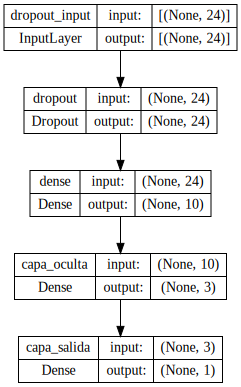

In [55]:
from IPython.display import SVG
from keras.utils import model_to_dot
display(SVG(model_to_dot(model, show_shapes=True,
                         dpi=72).create(prog="dot", format="svg")))

In [56]:
model.get_weights()

[array([[-0.25775546,  0.12482163, -0.00820026, -0.11669266,  0.1560947 ,
         -0.4194928 ,  0.32723364, -0.11502999,  0.08899638, -0.2654245 ],
        [ 0.33577564,  0.03017884,  0.31362757,  0.1780968 , -0.40982777,
          0.25218818,  0.0422163 , -0.35732147, -0.05795917,  0.37113228],
        [ 0.35797086, -0.3023925 , -0.37197638, -0.09745124,  0.0430586 ,
          0.18594632,  0.21478978,  0.39750007, -0.38112852,  0.30769578],
        [ 0.03973493, -0.41940168, -0.37786314,  0.15806845,  0.25965258,
         -0.32547793, -0.09936351, -0.09421569, -0.00570938,  0.18194881],
        [-0.11572698,  0.24172953,  0.31689999, -0.12717366,  0.23184451,
         -0.36033896, -0.01872793, -0.36576542, -0.3476283 , -0.14060447],
        [ 0.29103443,  0.02961567, -0.05352539,  0.19011173,  0.0986025 ,
         -0.28255165, -0.04212984, -0.17009917,  0.20918766,  0.16539297],
        [-0.1052734 ,  0.22355512,  0.12441567, -0.17780465,  0.2923033 ,
          0.20274797,  0.3525241

In [57]:
y_train.shape

(543,)

In [59]:
y_train

Customer ID
ADF1732    1
ADF1783    1
ADF1911    1
ADF1258    0
ADF1114    0
ADF1266    0
ADF1474    0
ADF1378    0
ADF0352    1
ADF1798    1
ADF1254    0
ADF1927    1
ADF0093    1
ADF1738    1
ADF1374    0
ADF0102    1
ADF1191    0
ADF0449    1
ADF0071    1
ADF1507    0
ADF0136    1
ADF1115    0
ADF0587    0
ADF1149    0
ADF1920    1
ADF1649    1
ADF0624    1
ADF1296    0
ADF1129    0
ADF1053    0
ADF0299    0
ADF1470    0
ADF0365    1
ADF1553    1
ADF1914    1
ADF1198    0
ADF1387    0
ADF1570    1
ADF1900    1
ADF0632    1
ADF0383    1
ADF0348    1
ADF1543    0
ADF1356    0
ADF1388    0
ADF1174    0
ADF1688    1
ADF1500    0
ADF1789    1
ADF1083    0
ADF1684    1
ADF0310    0
ADF0609    1
ADF0361    1
ADF0060    0
ADF0128    1
ADF0481    1
ADF1496    0
ADF0282    0
ADF1447    0
ADF0485    1
ADF0504    1
ADF1310    0
ADF1348    0
ADF0039    0
ADF0492    1
ADF1460    0
ADF1628    1
ADF1146    0
ADF1399    0
ADF1513    0
ADF1838    1
ADF1234    0
ADF0074    1
ADF1853    1
ADF1247    0


In [58]:
y_train[:5]

Customer ID
ADF1732    1
ADF1783    1
ADF1911    1
ADF1258    0
ADF1114    0
Name: Churn Status, dtype: int64

In [60]:
len(y_train), len(y_val), len(y_test)

(543, 234, 333)

## Entrenamiento del modelo

In [61]:
from keras.callbacks import ModelCheckpoint
modelpath = "best_model.h5" # fichero al que Keras grabará mejor modelo
checkpoint = ModelCheckpoint(
    modelpath, # fichero al que grabar el modelo
    #monitor="val_accuracy", # métrica que va a monitorizar checkpoint
    monitor="val_loss", # métrica que va a monitorizar checkpoint
    save_best_only = True, # graba fichero solo cuando encuentra máximo
    verbose=1 # "ve informándome por pantalla"
)

serie_tr_acc   = []
serie_val_acc  = []
serie_tr_loss  = []
serie_val_loss = []

In [62]:
epochs = 100

for e in range(epochs):
    salida = model.fit(X_train_est, y_train, epochs=1, callbacks=[checkpoint],
                       validation_data=(X_val_est, y_val), verbose=10)

    # métricas "normales" en training desactivando el dropout:
    loss, acc = model.evaluate(X_train_est, y_train)

    #serie_tr_acc.append(salida.history["accuracy"][0])
    serie_tr_acc.append(acc)
    serie_val_acc.append(salida.history["val_accuracy"][0])
    #serie_tr_loss.append(salida.history["loss"][0])
    serie_tr_loss.append(loss)
    serie_val_loss.append(salida.history["val_loss"][0])

    clear_output()
    grafica_entrenamiento(serie_tr_acc, serie_val_acc,
                          serie_tr_loss, serie_val_loss)

KeyboardInterrupt: ignored

In [63]:
model.get_weights()

[array([[-0.27803037,  0.11278793,  0.08644418, -0.02406683,  0.2769195 ,
         -0.26982552,  0.23779953, -0.19302072,  0.20609713, -0.1116184 ],
        [ 0.22936128,  0.09745899,  0.2554938 ,  0.31210837, -0.25970176,
          0.2888475 , -0.08514471, -0.46796808,  0.08028008,  0.5237325 ],
        [ 0.25702387, -0.23515606, -0.48093337, -0.00684897,  0.09637985,
          0.24171221,  0.13644464,  0.34753016, -0.28547138,  0.36949357],
        [ 0.16715123, -0.6386165 , -0.18122149,  0.07651303,  0.20693849,
         -0.10358955,  0.02509165,  0.07673236,  0.1640413 ,  0.3759451 ],
        [-0.27552256,  0.31067643,  0.24798763,  0.06377042,  0.39301667,
         -0.25093615, -0.18065111, -0.4865464 , -0.14386456,  0.05281606],
        [ 0.3365699 ,  0.00719225,  0.02937738,  0.20549768,  0.16540398,
         -0.23821132, -0.06454837, -0.20116666,  0.24054691,  0.25441703],
        [-0.0626413 ,  0.2168103 ,  0.17626637, -0.19297479,  0.3041196 ,
          0.1984357 ,  0.3521179

In [64]:
# leo el modelo de fichero:

In [65]:
from tensorflow.keras.saving import load_model
model = load_model(modelpath)

In [68]:
model.get_weights()

[array([[-0.2795829 ,  0.11550908,  0.08529982, -0.02222105,  0.27900842,
         -0.27124253,  0.23570561, -0.1956643 ,  0.20712961, -0.10994742],
        [ 0.23194991,  0.09541854,  0.25771797,  0.3090856 , -0.26242808,
          0.28902566, -0.08231082, -0.46528375,  0.07766066,  0.5213728 ],
        [ 0.25631806, -0.23374447, -0.4830869 , -0.00695732,  0.09549826,
          0.2397149 ,  0.13665165,  0.34779274, -0.285814  ,  0.3677664 ],
        [ 0.16423726, -0.6353682 , -0.18475552,  0.07827544,  0.20789987,
         -0.10619794,  0.02319983,  0.07447455,  0.16389005,  0.3741064 ],
        [-0.27458972,  0.31132588,  0.24873462,  0.06274774,  0.3928045 ,
         -0.25241652, -0.18018156, -0.486842  , -0.14558037,  0.05194779],
        [ 0.33527598,  0.00886452,  0.02797307,  0.20671432,  0.16658083,
         -0.23931   , -0.06586233, -0.20271744,  0.24112275,  0.25492036],
        [-0.06349784,  0.21735387,  0.17438234, -0.19338492,  0.3025571 ,
          0.19761215,  0.3527385

In [66]:
model.metrics_names


['loss', 'accuracy']

In [73]:
model.predict(X_test_est).flatten()

11/11 [==============================] - 0s 3ms/step


array([0.22812556, 0.2682498 , 0.3735605 , 0.96465415, 0.24205606,
       0.8053436 , 0.1997641 , 0.4063208 , 0.36254314, 0.31027701,
       0.42173076, 0.49065897, 0.41391388, 0.32510346, 0.28011823,
       0.4319691 , 0.8049375 , 0.7290005 , 0.3057421 , 0.58192146,
       0.8104932 , 0.3807767 , 0.70725095, 0.6241762 , 0.27744532,
       0.38761127, 0.61571914, 0.31289124, 0.42653948, 0.3510384 ,
       0.3000516 , 0.8851407 , 0.79008573, 0.5050548 , 0.2115258 ,
       0.373707  , 0.44572982, 0.2839565 , 0.8071095 , 0.3411409 ,
       0.33488202, 0.35268947, 0.63989276, 0.9097703 , 0.766318  ,
       0.7050038 , 0.37261492, 0.33965382, 0.7707634 , 0.36906126,
       0.44365457, 0.75468266, 0.4150718 , 0.44251317, 0.38485718,
       0.23159863, 0.7265141 , 0.6476751 , 0.3692299 , 0.7611255 ,
       0.5879137 , 0.72784704, 0.6399683 , 0.1375277 , 0.18645883,
       0.37687734, 0.37831697, 0.40612108, 0.7772891 , 0.4748295 ,
       0.55185825, 0.39898255, 0.44530234, 0.3063391 , 0.39841

In [69]:
# chequeo las métricas en validación:

print(model.metrics_names)
model.evaluate(X_val_est, y_val)

['loss', 'accuracy']
8/8 [==============================] - 0s 5ms/step - loss: 0.6507 - accuracy: 0.6667


[0.6507472395896912, 0.6666666865348816]

In [70]:
# chequeo las métricas en test:

print(model.metrics_names)
model.evaluate(X_test_est, y_test)

['loss', 'accuracy']
11/11 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.7027


[0.6065208315849304, 0.7027027010917664]

In [71]:
# chequeo las métricas en training:

print(model.metrics_names)
model.evaluate(X_train_est, y_train)

['loss', 'accuracy']
17/17 [==============================] - 0s 3ms/step - loss: 0.5592 - accuracy: 0.7311


[0.5591514110565186, 0.7311233878135681]

In [76]:
# realizo predicciones en training y chequeo el score:

np.mean(1*(model.predict(X_train_est).flatten()>0.5) == y_train)

17/17 [==============================] - 0s 3ms/step


0.7311233885819521

In [77]:
# hago lo mismo en validación:

np.mean(1*(model.predict(X_val_est).flatten()>0.5) == y_val)

8/8 [==============================] - 0s 2ms/step


0.6666666666666666

In [78]:
# Y en test:
np.mean(1*(model.predict(X_test_est).flatten()>0.5) == y_test)

11/11 [==============================] - 0s 2ms/step


0.7027027027027027

In [79]:
import pickle

datos = {
    "fecha": "13/10/2023",
    "scaler": scaler,
    "variables_usadas": X_train.columns.tolist()
}

with open("datos_adicionales_modelo1.pkl", "wb") as f:
  pickle.dump(datos, f)